In [3]:
import pandas as pd
from pathlib import Path

from sklearn.svm import LinearSVR,SVR
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import learning_curve,RepeatedKFold
from sklearn.decomposition import PCA

from yellowbrick.model_selection import LearningCurve
from yellowbrick.regressor import ResidualsPlot
from yellowbrick.regressor import PredictionError
from sklearn.preprocessing import StandardScaler,scale,RobustScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
from sklearn import metrics
from sklearn.externals import joblib
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import QuantileTransformer,quantile_transform,PowerTransformer

%matplotlib inline

In [2]:
sns.set_context(context="paper")

In [3]:
def learn_curves(estimator, features, target, cv):
    train_sizes, train_scores, validation_scores = learning_curve(
                                                 estimator, features, target,train_sizes = np.linspace(.1, 1.0, 10),
                                                 cv = cv, scoring = 'neg_mean_squared_error',n_jobs=-1)
    train_scores_mean = -train_scores.mean(axis = 1)
    validation_scores_mean = -validation_scores.mean(axis = 1)
    
    plt.plot(train_sizes, np.sqrt(train_scores_mean), label = 'Training error')
    plt.plot(train_sizes, np.sqrt(validation_scores_mean), label = 'Validation error')

    plt.ylabel('RMSE', fontsize = 14)
    plt.xlabel('Training set size', fontsize = 14)
    title = 'Learning curve'
    plt.title(title, fontsize = 18, y = 1.03)
    plt.legend()
    plt.ylim(0,3)

In [4]:

#dataframe final
df_final = pd.read_csv("../data/DF_contact400_energy_sasa.FcorrZero.csv",index_col=0)

index_ddg8 = (df_final['ddG_exp']>6.3)
df_final = df_final.loc[-index_ddg8]
#testiar eliminando estructuras con ddg menor o igual a -4 kcal/mol , outliers
index_ddg_4 =  (df_final['ddG_exp'] <= -4)
df_final = df_final.loc[-index_ddg_4]


pdb_names = df_final.index
features_names = df_final.drop('ddG_exp',axis=1).columns


In [5]:
df_final.shape

(609, 237)

In [1]:
#X = df_final_f1 # con filtrado de varianza
X = df_final.drop('ddG_exp',axis=1).astype(float)
y = df_final['ddG_exp']

NameError: name 'df_final' is not defined

In [2]:
# binned split
bins = np.linspace(0, len(X), 50)
y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned,random_state=1)                                                    

NameError: name 'np' is not defined

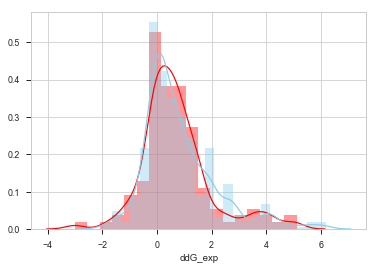

In [8]:
sns.distplot( y_test , color="red", label="ddG_exp_test")
sns.distplot( y_train , color="skyblue", label="ddG_exp_train")


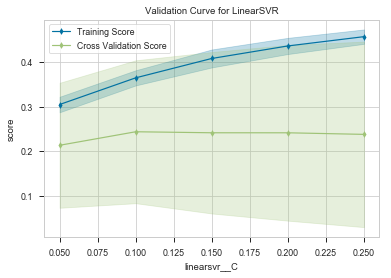

In [18]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

# Load a regression dataset

selector = VarianceThreshold()
scaler = MinMaxScaler()
trf = PowerTransformer()
#2)
lr_model = LinearSVR(max_iter=8000)
#3) Crear pipeline
pipeline1 = make_pipeline(scaler,selector,lr_model)

regr_trans = TransformedTargetRegressor(
    regressor=pipeline1, transformer=PowerTransformer())


# Extract the instances and target
viz = ValidationCurve(
    pipeline1, njobs=-1,param_name="linearsvr__C",
    param_range=np.arange(0.05,0.3,0.05), cv=10, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

# LinearSVR gridsearch

In [ ]:
Rep

In [27]:
selector = VarianceThreshold()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#2)
lr_model = LinearSVR(max_iter=8000)
#3) Crear pipeline
pipeline1 = make_pipeline(scaler,selector,lr_model)

regr_trans = TransformedTargetRegressor(
    regressor=pipeline1, transformer=PowerTransformer())

# 5) hiperparametros a ajustar
param_grid = { 'regressor__linearsvr__C': [0.05,0.1,0.15,0.2] , 'regressor__linearsvr__epsilon':[1.2,1.3,1.4,1.5],
              'regressor__linearsvr__random_state': [1313],'regressor__linearsvr__fit_intercept':[False,True],
             'regressor__variancethreshold__threshold':[0.001,0.0015,0.0]}

cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=13,)

grid1 = GridSearchCV(regr_trans, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)

grid1.fit(X_train, y_train)


Fitting 50 folds for each of 96 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 1376 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 2348 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done 3536 tasks      | elapsed:   15.0s
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:   20.1s finished
/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a1cff3630>,
       error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('linearsvr', LinearSVR(C=1.0, du...))]),
              transformer=PowerTransformer(copy=True, method='yeo-johnson', standardize=True)),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'regressor__linearsvr__C': [0.05, 0.1, 0.15, 0.2], 'regressor__linearsvr__epsilon': [1.2, 1.3, 1.4, 1.5], 'regressor__linearsvr__random_state': [1313], 'regressor__linearsvr__fit_intercept': [False, True], 'regressor__variancethreshold__threshold': [0.001, 0.0015, 0.0]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbo

In [28]:
# index of best scores
rmse_bestCV_test_index = grid1.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid1.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid1.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid1.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid1.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid1.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid1.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid1.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid1.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid1.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid1.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid1.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid1.best_params_)
y_test_pred = grid1.best_estimator_.predict(X_test)
y_train_pred = grid1.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',grid1.score(X_test,y_test))
print('R2 train',grid1.score(X_train,y_train))

CV test RMSE 1.122977 +/- 0.437749
CV train RMSE 1.054260 +/- 0.233210
CV test r2 0.267013 +/- 0.083922
CV train r2 0.366414 +/- 0.014300
0.09940101699371978
 {'regressor__linearsvr__C': 0.1, 'regressor__linearsvr__epsilon': 1.2, 'regressor__linearsvr__fit_intercept': False, 'regressor__linearsvr__random_state': 1313, 'regressor__variancethreshold__threshold': 0.001}

RMSE for test dataset: 1.09
RMSE for train dataset: 1.07
pearson corr  0.550581
R2 test 0.2762826462622363
R2 train 0.3464067612013476


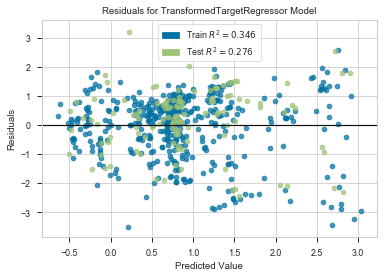

In [29]:
visualizer = ResidualsPlot(grid1.best_estimator_,hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

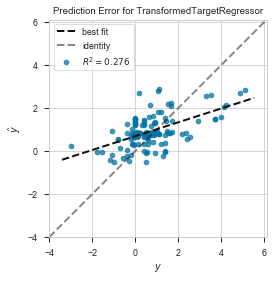

In [30]:
perror = PredictionError(grid1.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof() 

/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))
/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


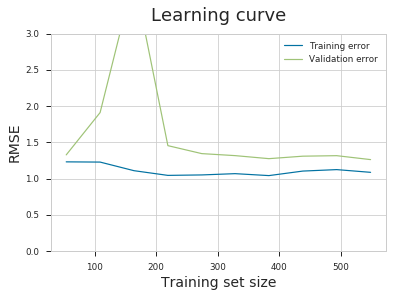

In [15]:
learn_curves(grid1.best_estimator_,X,y,10)


/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/numpy/core/_methods.py:117: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


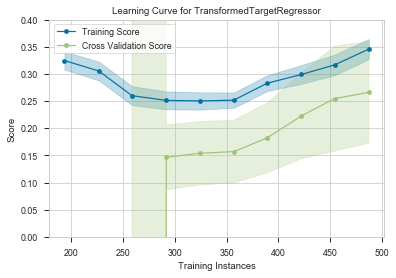

In [34]:
viz = LearningCurve(grid1.best_estimator_, cv=cv, n_jobs=-1,scoring='r2',train_sizes=np.linspace(0.4, 1.0, 10))
viz.fit(X, y)
plt.ylim(0,0.4)
viz.poof()

In [42]:
final_svr1 = grid1.best_estimator_.fit(X,y)
# save final model

joblib.dump(final_svr1, 'SVRmodel_contact400energy_sasa_linear.pkl')

['SVRmodel_contact400energy_sasa_linear.pkl']

# SVR poly, rbf kernel gridsearch

In [188]:
SVR?

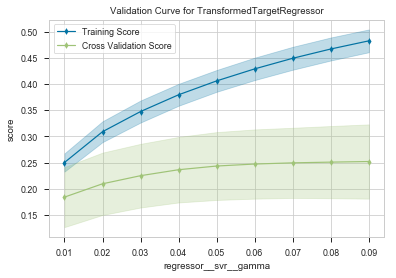

In [48]:
import numpy as np

from yellowbrick.model_selection import ValidationCurve

# Load a regression dataset

selector = VarianceThreshold()
scaler = MinMaxScaler()
#scaler = StandardScaler()
#2)
lr_model = SVR(max_iter=8000,kernel="rbf")
#3) Crear pipeline
pipeline2 = make_pipeline(scaler,selector,lr_model)
regr_trans = TransformedTargetRegressor(
    regressor=pipeline2, transformer=PowerTransformer())

# Extract the instances and target
viz = ValidationCurve(
    regr_trans, njobs=-1,param_name="regressor__svr__gamma",
    param_range=np.arange(0.01,0.1,0.01), cv=cv, scoring="r2"
)
#plt.ylim(0,0.6)
# Fit and poof the visualizer
viz.fit(X_train, y_train)
viz.poof()

In [81]:
selector = VarianceThreshold()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#2)
lr_model = SVR(max_iter=8000)
#3) Crear pipeline
pipeline2 = make_pipeline(scaler,selector,lr_model)


# 5) hiperparametros a ajustar
param_grid = { 'regressor__svr__kernel': ['rbf'],'regressor__svr__C': [1.5],'regressor__svr__gamma': [0.025],
              'regressor__svr__epsilon':[0.9],'regressor__variancethreshold__threshold':[0.001] }

cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=13)
regr_trans = TransformedTargetRegressor(
    regressor=pipeline2, transformer=PowerTransformer())

grid2 = GridSearchCV(regr_trans, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)
# fit
grid2.fit(X_train, y_train)

Fitting 50 folds for each of 1 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:    0.4s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  30 out of  50 | elapsed:    0.5s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:    0.7s finished


GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x1a1d236828>,
       error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('svr', SVR(C=1.0, cache_size=200...))]),
              transformer=PowerTransformer(copy=True, method='yeo-johnson', standardize=True)),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'regressor__svr__kernel': ['rbf'], 'regressor__svr__C': [1.5], 'regressor__svr__gamma': [0.025], 'regressor__svr__epsilon': [0.9], 'regressor__variancethreshold__threshold': [0.001]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbose=5)

In [82]:
# index of best scores
rmse_bestCV_test_index = grid2.cv_results_['mean_test_neg_mean_squared_error'].argmax()
rmse_bestCV_train_index = grid2.cv_results_['mean_train_neg_mean_squared_error'].argmax()
r2_bestCV_test_index = grid2.cv_results_['mean_test_r2'].argmax()
r2_bestCV_train_index = grid2.cv_results_['mean_train_r2'].argmax()
# scores
rmse_bestCV_test_score = grid2.cv_results_['mean_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_test_std = grid2.cv_results_['std_test_neg_mean_squared_error'][rmse_bestCV_test_index]
rmse_bestCV_train_score = grid2.cv_results_['mean_train_neg_mean_squared_error'][rmse_bestCV_train_index]
rmse_bestCV_train_std = grid2.cv_results_['std_train_neg_mean_squared_error'][rmse_bestCV_train_index]

r2_bestCV_test_score = grid2.cv_results_['mean_test_r2'][r2_bestCV_test_index]
r2_bestCV_test_std = grid2.cv_results_['std_test_r2'][r2_bestCV_test_index]
r2_bestCV_train_score = grid2.cv_results_['mean_train_r2'][r2_bestCV_train_index]
r2_bestCV_train_std = grid2.cv_results_['std_train_r2'][r2_bestCV_train_index]

print('CV test RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_test_score),np.sqrt(rmse_bestCV_test_std)))
print('CV train RMSE {:f} +/- {:f}'.format(np.sqrt(-rmse_bestCV_train_score),np.sqrt(rmse_bestCV_train_std)))
print('CV test r2 {:f} +/- {:f}'.format(r2_bestCV_test_score,r2_bestCV_test_std))
print('CV train r2 {:f} +/- {:f}'.format(r2_bestCV_train_score,r2_bestCV_train_std))

print(r2_bestCV_train_score-r2_bestCV_test_score)
print("",grid2.best_params_)
y_test_pred = grid2.best_estimator_.predict(X_test)
y_train_pred = grid2.best_estimator_.predict(X_train)
print("\nRMSE for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 2)))
print("RMSE for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 2)))
print("pearson corr  {:f}".format(np.corrcoef(y_test_pred,y_test)[0][1]))
print('R2 test',grid2.score(X_test,y_test))
print('R2 train',grid2.score(X_train,y_train))

CV test RMSE 1.134333 +/- 0.460026
CV train RMSE 1.040422 +/- 0.205267
CV test r2 0.255261 +/- 0.063416
CV train r2 0.382609 +/- 0.016005
0.12734770129026102
 {'regressor__svr__C': 1.5, 'regressor__svr__epsilon': 0.9, 'regressor__svr__gamma': 0.025, 'regressor__svr__kernel': 'rbf', 'regressor__variancethreshold__threshold': 0.001}

RMSE for test dataset: 1.04
RMSE for train dataset: 1.04
pearson corr  0.594789
R2 test 0.3406995998879291
R2 train 0.3833997914769536


In [ ]:
CV test RMSE 1.136342 +/- 0.483132
CV train RMSE 1.038431 +/- 0.220192
CV test r2 0.255360 +/- 0.058354
CV train r2 0.385056 +/- 0.018497
0.12969578040681795
 {'regressor__svr__C': 2, 'regressor__svr__epsilon': 0.6, 'regressor__svr__gamma': 0.03, 'regressor__svr__kernel': 'rbf'}

RMSE for test dataset: 1.07
RMSE for train dataset: 1.04
pearson corr  0.555573
R2 test 0.30467618432470744
R2 train 0.38296278782456605

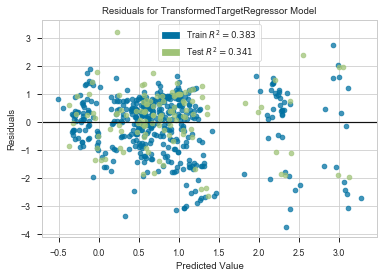

In [83]:
visualizer = ResidualsPlot(grid2.best_estimator_,hist=False)

visualizer.fit(X_train, y_train)  # Fit the training data to the model
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.poof()                 # Draw/show/poof the data

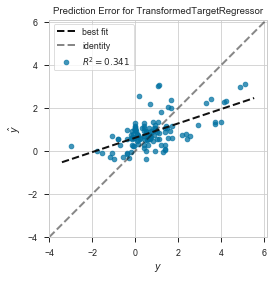

In [84]:
perror = PredictionError(grid2.best_estimator_)

perror.fit(X_train, y_train)  # Fit the training data to the visualizer
perror.score(X_test, y_test)  # Evaluate the model on the test data
g = perror.poof()

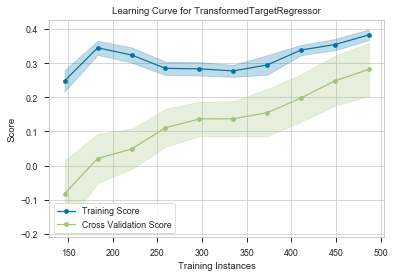

In [85]:
viz = LearningCurve(grid2.best_estimator_, cv=cv, n_jobs=-1,scoring='r2',train_sizes=np.linspace(0.3, 1.0, 10))
viz.fit(X, y)
#plt.ylim(5,-5)
viz.poof()

In [86]:
final_svr2 = grid2.best_estimator_.fit(X,y)
# save final model

joblib.dump(final_svr2, 'SVRmodel_contact400energy_sasa_rbf.pkl')


['SVRmodel_contact400energy_sasa_rbf.pkl']

# Poly kernel

In [47]:
selector = VarianceThreshold()
scaler = MinMaxScaler()
#scaler = RobustScaler()
#2)
lr_model = SVR(max_iter=8000)
#3) Crear pipeline
pipeline3 = make_pipeline(scaler,selector,lr_model)


# 5) hiperparametros a ajustar
param_grid = { 'regressor__svr__kernel': ['poly'],'regressor__svr__C': [3,4,5,6],'regressor__svr__gamma': [0.02,0.03,0.04,0.05],
              'regressor__svr__epsilon':[0.6,0.7],'regressor__svr__degree':[4,5,6] }

cv = RepeatedKFold(n_splits=5,n_repeats=10,random_state=13)
regr_trans = TransformedTargetRegressor(
    regressor=pipeline3, transformer=PowerTransformer())

grid3 = GridSearchCV(regr_trans, param_grid, verbose=5, n_jobs=-1,cv=cv,scoring=['neg_mean_squared_error','r2'],
                        refit='r2',return_train_score=True)
# fit
grid3.fit(X_train, y_train)

Fitting 50 folds for each of 96 candidates, totalling 4800 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 552 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 876 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1272 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 1740 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 2280 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 2892 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 3576 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 4332 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 4800 out of 4800 | elapsed:  2.3min finished
/home/vilion/miniconda3/envs/bio/lib/python3.6/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will ch

GridSearchCV(cv=<sklearn.model_selection._split.RepeatedKFold object at 0x7fe1e6d9b518>,
       error_score='raise-deprecating',
       estimator=TransformedTargetRegressor(check_inverse=True, func=None, inverse_func=None,
              regressor=Pipeline(memory=None,
     steps=[('minmaxscaler', MinMaxScaler(copy=True, feature_range=(0, 1))), ('variancethreshold', VarianceThreshold(threshold=0.0)), ('svr', SVR(C=1.0, cache_size=200...))]),
              transformer=PowerTransformer(copy=True, method='yeo-johnson', standardize=True)),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'regressor__svr__kernel': ['poly'], 'regressor__svr__C': [3, 4, 5, 6], 'regressor__svr__gamma': [0.02, 0.03, 0.04, 0.05], 'regressor__svr__epsilon': [0.6, 0.7], 'regressor__svr__degree': [4, 5, 6]},
       pre_dispatch='2*n_jobs', refit='r2', return_train_score=True,
       scoring=['neg_mean_squared_error', 'r2'], verbose=5)

In [49]:
grid3.best_score_

0.1661915009799666

# Best estimators with smote

In [69]:
from imblearn import over_sampling as ovs


In [265]:
# forma 1
df_final['class'] = np.where((df_final['ddG_exp'] <= -0.5) | (df_final['ddG_exp'] >= 2),0,1)
# forma 2 
#df_final['class'] = np.where((df_final['ddG_exp'] < 0),1,0)

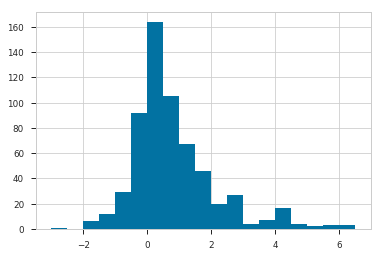

In [266]:
df_final['ddG_exp'].hist(bins=np.arange(-3,7,0.5))


In [267]:
print("Before OverSampling, counts of label '1': {}".format(sum(df_final['class'] == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(df_final['class'] == 0)))

Before OverSampling, counts of label '1': 470
Before OverSampling, counts of label '0': 139


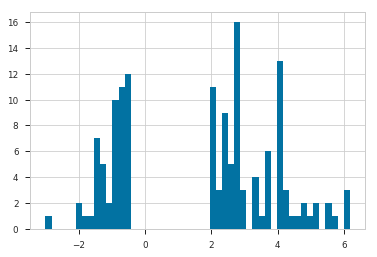

In [268]:
df_final.loc[df_final['class'] == 0]['ddG_exp'].hist(bins=50)

In [269]:
X = df_final.drop('class',axis=1)
y = df_final['class']

In [270]:
# binned split
bins = np.linspace(0, len(X), 50)
y_binned = np.digitize(y, bins)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y_binned,random_state=1)    

In [285]:
smote = ovs.SMOTE(random_state=12,m_neighbors=3)
#smote = ovs.BorderlineSMOTE(random_state=12,m_neighbors=3,kind='borderline-2')
#adasyn = ovs.ADASYN(random_state=10,n_neighbors=5)
#X_train_re , y_train_re = adasyn.fit_sample(X_train,y_train)
X_train_re , y_train_re = smote.fit_sample(X_train,y_train)

In [286]:
# back to originalk shape and target
X_train_normal = X_train_re[:,:-1]
y_train_normal = X_train_re[:,-1]

X_test_normal = X_test.iloc[:,:-1]
y_test_normal = X_test.iloc[:,-1]

In [289]:
model = grid2.best_estimator_.fit(X_train_normal,y_train_normal)
#print('CV test RMSE',np.sqrt(-grid.best_score_))
#print('CV train RMSE',np.sqrt(-grid.cv_results_['mean_train_score'].max()))

y_test_pred = model.predict(X_test_normal.values)
y_train_pred = model.predict(X_train_normal)

print('Training score (r2): {}'.format(r2_score(y_train_normal, y_train_pred)))
print('Test score (r2): {}'.format(r2_score(y_test_normal.values, y_test_pred)))

print("\nRoot mean square error for test dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_test_normal.values, y_test_pred)), 2)))
print("Root mean square error for train dataset: {}".format(np.round(np.sqrt(mean_squared_error(y_train_normal, y_train_pred)), 2)))
print("pearson corr: ",np.corrcoef(y_test_pred,y_test_normal.values)[0][1])

Training score (r2): 0.5591430525016399
Test score (r2): 0.26508378862896087

Root mean square error for test dataset: 1.23
Root mean square error for train dataset: 1.08
pearson corr:  0.5443643460426142


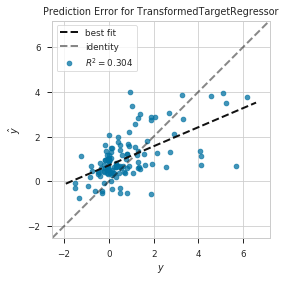

In [284]:
perror = PredictionError(model)

perror.fit(X_train_normal, y_train_normal)  # Fit the training data to the visualizer
perror.score(X_test_normal.values, y_test_normal.values)  # Evaluate the model on the test data
g = perror.poof()

## Salvar modelo final, entrenado con el total de lso datos

In [171]:
ABPRED_DIR = Path().cwd().parent
DATA = ABPRED_DIR / "data"

#dataframe final
df_final = pd.read_csv(DATA/"../data/DF_features_400_2019.csv",index_col=0)
# Quitar modelos por homologia deltraining set
#df_final_onlyHM = df_final.loc[df_final.index.str.startswith("HM")]
#df_final= df_final.loc[~df_final.index.str.startswith("HM")]

index_ddg8 = (df_final['ddG(kcal/mol)']==8)
df_final = df_final.loc[-index_ddg8]
#testiar eliminando estructuras con ddg menor o igual a -4 kcal/mol , outliers
index_ddg_4 =  (df_final['ddG(kcal/mol)'] <= -4)
df_final = df_final.loc[-index_ddg_4]


pdb_names = df_final.index
features_names = df_final.drop('ddG(kcal/mol)',axis=1).columns

In [172]:
# forma 1
df_final['class'] = np.where((df_final['ddG(kcal/mol)'] < -0.4) | (df_final['ddG(kcal/mol)'] > 2.4),0,1)
# forma 2 
#df_final['class'] = np.where((df_final['ddG(kcal/mol)'] < 0),1,0)

In [173]:
print("Before OverSampling, counts of label '1': {}".format(sum(df_final['class'] == 1)))
print("Before OverSampling, counts of label '0': {}".format(sum(df_final['class'] == 0)))

Before OverSampling, counts of label '1': 481
Before OverSampling, counts of label '0': 134


In [174]:
X = df_final.drop('class',axis=1)
y = df_final['class']

In [175]:
smote = ovs.SMOTE(random_state=12,m_neighbors=25)
X_re , y__re = smote.fit_sample(X,y)

In [176]:
# back to originalk shape and target
X_normal = X_re[:,:-1]
y_normal = X_re[:,-1]

In [179]:
final_svr = grid1.best_estimator_.fit(X_normal,y_normal)

In [180]:
# save final model

joblib.dump(final_svr, 'SVRmodel_400.linear.v1.pkl')


['SVRmodel_400.linear.v1.pkl']

/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(4.5,-0.5,'RMSE = 1.043')

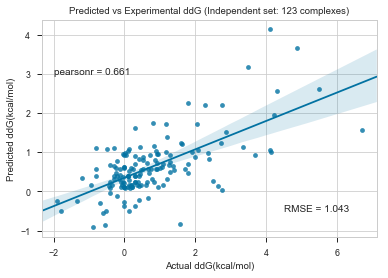

In [122]:
rmse_test = np.round(np.sqrt(mean_squared_error(y_test, y_test_pred)), 3)
df_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_test_pred, "Actual ddG(kcal/mol)": y_test.values})
pearsonr_test = round(df_pred.corr().iloc[0,1],3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_pred)
plt.title("Predicted vs Experimental ddG (Independent set: 123 complexes)")

plt.text(-2,3,"pearsonr = %s" %pearsonr_test)
plt.text(4.5,-0.5,"RMSE = %s" %rmse_test)

#plt.savefig("RFmodel_300_testfit.png",dpi=600)

/Users/vfica/miniconda3/envs/bio/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5,1,'Predicted vs Experimental ddG (Train set: 492 complexes)')

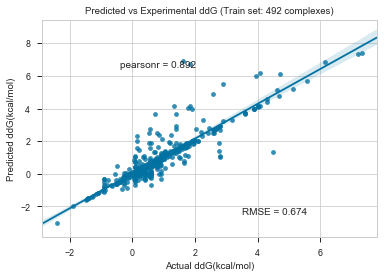

In [123]:
df_train_pred = pd.DataFrame({"Predicted ddG(kcal/mol)": y_train, "Actual ddG(kcal/mol)": y_train_pred})
pearsonr_train = round(df_train_pred.corr().iloc[0,1],3)
rmse_train = np.round(np.sqrt(mean_squared_error(y_train, y_train_pred)), 3)

g = sns.regplot(x="Actual ddG(kcal/mol)", y="Predicted ddG(kcal/mol)",data=df_train_pred)

plt.text(-0.4,6.5,"pearsonr = %s" %pearsonr_train)
plt.text(3.5,-2.5,"RMSE = %s" %rmse_train)
plt.title("Predicted vs Experimental ddG (Train set: 492 complexes)")
#plt.savefig("RFmodel_300_trainfit.png",dpi=600)
